**Name:** Yidu Wu

**EID:** yiduwu2

**Kaggle Team Name:** Yidu WU

# CS5489 - Assignment 2 - Sound Effects Tagging
# FINAL SOLUTION
Due date: see Assignment 2 on Canvas

In [2]:
%matplotlib inline
import IPython.core.display         
# setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
from scipy import stats
random.seed(100)
import csv
from scipy import io
import pickle
from IPython.display import Audio, display

In [3]:
def showAudio(info):
    display(Audio(info['previews']['preview-lq-mp3']))

def load_pickle(fname):
    f = open(fname, 'rb')
    out = pickle.load(f)
    f.close()
    return out

In [4]:
train_tags  = load_pickle('train_tags.pickle3')
train_mfccs = load_pickle('train_mfccs.pickle3')
train_info  = load_pickle('train_info.pickle3')

test_mfccs = load_pickle('test_mfccs.pickle3')
test_info  = load_pickle('test_info.pickle3')

In [5]:
# compute delta MFCCs
def compute_delta_mfccs(mfccs):
    dmfccs = []
    for m in mfccs:
        tmp = m[1:] - m[0:-1]
        dm = hstack((m[0:-1], tmp))
        dmfccs.append(dm)
    return dmfccs

In [6]:
train_dmfccs = compute_delta_mfccs(train_mfccs)
test_dmfccs  = compute_delta_mfccs(test_mfccs)

In [7]:
tagnames, tagnames_counts = unique(concatenate(train_tags), return_counts=True)
for a,b in zip(tagnames, tagnames_counts):
    print("{}: {}".format(a, b))

acoust: 100
analog: 100
bass: 160
beat: 128
drum: 371
effect: 141
electron: 194
field: 110
glitch: 110
guitar: 130
hit: 110
loop: 237
machin: 100
metal: 117
nois: 199
percuss: 285
record: 192
space: 125
synth: 220
synthes: 136
vocal: 120
voic: 167


In [8]:
# convert list of tags into binary class labels
def tags2class(tags, tagnames):
    b = zeros(shape=(len(tags), len(tagnames)))
    for i,t in enumerate(tags):
        for j,n in enumerate(tagnames):
            if n in t:
                b[i,j] = 1
    return b

In [9]:
# train_classes[i,j] = absence/presence of the j-th tag in the i-th sound
train_classes = tags2class(train_tags, tagnames)

In [10]:
# double check we did this correctly...
# it should be the same as the tag counts above
sum(train_classes,axis=0)

array([100., 100., 160., 128., 371., 141., 194., 110., 110., 130., 110.,
       237., 100., 117., 199., 285., 192., 125., 220., 136., 120., 167.])

In [11]:
import csv

def write_csv_kaggle_tags(fname, tagnames, Yscores):
    # header
    tmp = [['Id']]
    for t in tagnames:
        tmp[0].append(t)    
    
    # add ID numbers for each Y, and usage if necessary
    for i in range(len(Yscores)):
        tmp2 = [(i+1)]
        for t in range(len(tagnames)):
            tmp2.append(Yscores[i,t])
        
        tmp.append(tmp2)
        
    # write CSV file
    f = open(fname, 'w')
    writer = csv.writer(f)
    writer.writerows(tmp)
    f.close()

## YOUR CODE and DOCUMENTATION HERE

In [12]:
def bow_transform(model, mfccs):
    numwords = model.cluster_centers_.shape[0]
    bows = zeros((len(mfccs), numwords))
    for i in range(len(mfccs)):
        w = model.predict(mfccs[i])
        bw = bincount(w, minlength=numwords)
        bows[i,:] = bw
    return bows

In [13]:
# plot an ROC curve using class labels and class scores
def plot_roc(tagnames, Yclasses, Yscores):
    fprall = []
    tprall = []
    aucall = []
    for i in range(len(tagnames)):
        fpr, tpr, thresholds = metrics.roc_curve(Yclasses[:,i], Yscores[:,i])
        plt.plot(fpr, tpr, lw=0.5, alpha=0.5)
        auc = metrics.auc(fpr, tpr)
        fprall.append(fpr)
        tprall.append(tpr)
        aucall.append(auc)

    # Then interpolate all ROC curves at this points
    all_fpr = unique(concatenate(fprall))
    mean_tpr = zeros_like(all_fpr)
    for i in range(len(tagnames)):
        mean_tpr += interp(all_fpr, fprall[i], tprall[i])

    # Finally average it and compute AUC
    mean_tpr /= len(tagnames)

    # auc of the average ROC curve
    auc = metrics.auc(all_fpr, mean_tpr)

    # average AUC
    mc_auc = mean(aucall)

    plt.plot(all_fpr, mean_tpr, 'k-', lw=2)
    plt.title('MCAUC={:.4f}, AUC={:.4f}'.format(mc_auc, auc))

    plt.grid(True)

In [14]:
all_dmfccs = vstack(train_dmfccs)
print(all_dmfccs.shape)

(391816, 26)


In [20]:
pca = decomposition.PCA(n_components=17)
W   = pca.fit_transform(all_dmfccs)
print(W.shape)
bows = cluster.MiniBatchKMeans(n_clusters=500, random_state=5489, n_init=10)
bows.fit(W) 

(391816, 17)


MiniBatchKMeans(n_clusters=500, n_init=10, random_state=5489)

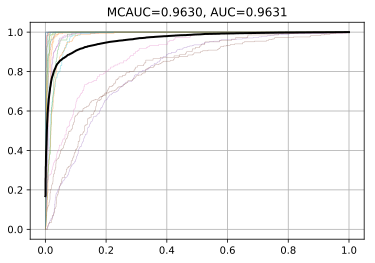

In [21]:
trainXn = []
for item in train_dmfccs:
    Wt   = pca.transform(item) 
    trainXn.append(Wt)
testXn = []
for item in test_dmfccs:
    Wt   = pca.transform(item) 
    testXn.append(Wt)
train_bow = bow_transform(bows, trainXn)
test_bow  = bow_transform(bows, testXn)
tf_trans = feature_extraction.text.TfidfTransformer(use_idf=True, norm='l1')
train_Xtf = tf_trans.fit_transform(train_bow)
test_Xtf  = tf_trans.transform(test_bow)
tagmodels = {}
for i,t in enumerate(tagnames):
    myY = train_classes[:,i].ravel()
    lr = linear_model.LogisticRegressionCV(Cs=logspace(-4,4,20), cv=5, class_weight='balanced', solver='liblinear')
    lr.fit(train_Xtf, myY)
    tagmodels[t] = lr
train_predscore = zeros(shape=(len(train_mfccs), len(tagnames)))

for i,t in enumerate(tagnames):
    tmp = tagmodels[t].decision_function(train_Xtf)
    train_predscore[:,i] = tmp
    
plot_roc(tagnames, train_classes, train_predscore)

In [17]:
# convert binary class vector into a list of tags
def class2tags(classes, tagnames):
    tags = []
    for n in range(classes.shape[0]):
        tmp = []
        for i in range(classes.shape[1]):
            if classes[n,i]:
                tmp.append(tagnames[i])
        tags.append(" ".join(tmp))
    return tags

In [22]:
test_predscore = zeros(shape=(len(test_mfccs), len(tagnames)))

for i,t in enumerate(tagnames):
    tmp = tagmodels[t].decision_function(test_Xtf)
    test_predscore[:,i] = tmp

test_predclass = test_predscore>0

# convert to tags
test_predtags = class2tags(test_predclass, tagnames)

In [23]:
write_csv_kaggle_tags("sounds_test_kaggle_bow_baseline.csv", tagnames, test_predscore)